# Implementations

This notebook delves into the world of ECC implementations.

 - You will first [analyze traces](#Manual-analysis) collected from a Curve25519 implementation to learn information about the implementation.
    - How many iterations are in the scalar multiplier?
    - Is the scalar multiplier left-to-right or right-to-left?
 - Then you will explore the number of ECC implementations [combinatorially](#Implementation-space).

## Manual analysis

[sca25519](https://github.com/sca-secure-library-sca25519/sca25519) is an open-source implementation of the Curve25519 key-exchange (XDH) for the ARM Cortex-M4. It contains three **implementations**:

 - unprotected
 - ephemeral
 - static

that contain different countermeasures, with the unprotected one being free of any.

You will work with three trace sets of scalar multiplication:
 - **A**: [Download](https://neuromancer.sk/static/traces_A.pickle) Traces of the full scalar multiplication. 10 traces per implementation: all implementations. Fixed scalar and point.
 - **B**: [Download](https://neuromancer.sk/static/traces_B.pickle) Traces of the beginning of the scalar multiplication. 1000 traces. Unprotected implementation. Random scalar.
 - **C**: [Download](https://neuromancer.sk/static/traces_C.pickle) Traces of the end of the scalar multiplication. 1000 traces. Unprotected implementation. Random scalar. 

In [1]:
from pyecsca.sca.trace_set import PickleTraceSet, HDF5TraceSet
from pyecsca.sca.trace import Trace
from pyecsca.sca.trace.plot import plot_trace, plot_traces
from pyecsca.ec.params import get_params
from pyecsca.ec.point import Point
from pyecsca.ec.mod import Mod

import holoviews as hv
import numpy as np

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
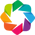

In [2]:
hv.extension("bokeh")
%opts RGB [height=600, responsive=True]

In [3]:
curve25519 = get_params("other", "Curve25519", "xz")
p = curve25519.curve.prime
n = curve25519.order

### <span style="color:#00468C; font-weight: bold;">Exercise</span>

Use trace set **A** and visually analyze the traces:

 - Plot them.
 - Compare them between implementations.
 - Process them using e.g. rolling mean and count peaks on them.
 - How many iterations does the scalar multiplier have in the unprotected case?

**Docs**<br/>
[plot module](https://neuromancer.sk/pyecsca/api/pyecsca.sca.trace.plot.html)<br/>
[scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

In [20]:
from pyecsca.sca.trace.plot import plot_trace, plot_traces
from pyecsca.sca.trace.process import rolling_mean
from scipy.signal import find_peaks

def plot_trace_peaks(peaks, trace):
    return plot_trace(trace) * hv.Points((peaks, trace.samples[peaks])).opts(color="red")

In [23]:
traces_A = PickleTraceSet.read("../traces_A.pickle")

In [24]:
traces_A

PickleTraceSet(num_traces=30, )

In [10]:
# Task: Plot two traces from the unprotected implementation.
# Hint: Look at the .meta attribute of the traces.
plot_traces(traces_A[0], traces_A[1])

:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [x,y]   (R,G,B,A)
      .RGB.II :RGB   [x,y]   (R,G,B,A)

In [11]:
# Task: Plot traces from the other implementations.
plot_traces(traces_A[10])

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In [12]:
plot_traces(traces_A[20])

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In [13]:
# Task: Use rolling_mean and find_peaks to count the iterations in the unprotected implementation
# Note: Before applying the rolling mean, make sure to transform the dtype of the trace by doing trace.astype(np.float32) and using the result.
# Hint: You can use plot_trace_peaks to plot the trace along with the detected peaks from find_peaks.
meany = rolling_mean(traces_A[0].astype(np.float32), 5000)
peaks, other = find_peaks(meany.samples, height=10, distance=5000)
print(len(peaks))
plot_trace_peaks(peaks, meany)

254


:DynamicMap   []
   :Overlay
      .RGB.I    :RGB   [x,y]   (R,G,B,A)
      .Points.I :Points   [x,y]

### <span style="color:#00468C; font-weight: bold;">Exercise</span>

Use trace set **B** and correlate the most significant bits of the scalar with the trace set.

 - Is the multiplier left-to-right or right-to-left?

> Note: The correlation computation takes a fair bit of memory (4-8GB), make sure you have it. **This will likely not work on myBinder.**


**Docs**<br/>
[StackedTraces](https://neuromancer.sk/pyecsca/api/pyecsca.sca.stacked_traces.stacked_traces.html#pyecsca.sca.stacked_traces.stacked_traces.StackedTraces)<br/>
[CPUTraceManager.pearson_corr](https://neuromancer.sk/pyecsca/api/pyecsca.sca.stacked_traces.combine.html#pyecsca.sca.stacked_traces.combine.CPUTraceManager.pearson_corr)<br/>
[Leakage models, Hamming Weight, Bit](https://neuromancer.sk/pyecsca/api/pyecsca.sca.attack.leakage_model.html)

In [4]:
from pyecsca.sca.stacked_traces import StackedTraces, CPUTraceManager
from pyecsca.sca.attack.leakage_model import HammingWeight, Bit
from pyecsca.sca.trace.plot import plot_trace, plot_traces
from pyecsca.sca.trace.process import normalize, rolling_mean

In [26]:
#traces_B = PickleTraceSet.read("../traces_B.pickle")
print(traces_B)

PickleTraceSet(num_traces=1000, )


In [7]:
stacked_B = StackedTraces.fromtraceset(traces_B)
mng_B = CPUTraceManager(stacked_B)

In [8]:
for trace in traces_B[:10]:
    scalar = int(trace.meta["scalar"])
    print(scalar.bit_length(), bin(scalar))

255 0b110011110101111101110000101110111001000010011001000111100101101110110101111001111011110010001011001011011100110001100000101111000011100010001011100100000010100101110110100010111011101001100000110010001101000111101101111011011011111010100000111111111100000
255 0b111010101010001011001111000011101000010000100111000101110011100010111010110111101101100110011011101010101000111010001101111010010000000110010011101000010010110011011111000101110000101101011100000111000000100111110011101111011101001011011011001110011011000
255 0b110110110111100011101000100111010010001111100010001000010010100000100011100100111111100000000001101000111010101001001101010100010111101111000000101100101111110001110100111110110101001110011000101100101000001001001000111011001000111010110101111100010100000
255 0b1001000111100001100010101010011101101100001110101110001000001010001101111011110000101000001001101110010100110001100101001101010110001010110001100011111100110100000100010100101100001101010000010011111011001110

In [9]:
corrs = []
for i in (253, 252, 251):
    lm = Bit(i)
    ivs = np.array(list(map(lambda t: lm(t.meta["scalar"]), traces_B)))
    corrs.append(normalize(Trace(mng_B.pearson_corr(ivs))))

In [10]:
plot_traces(*corrs)# it looks good but i would do 3 separate graphs one after another - then it is more visible. What do you think?

Traceback (most recent call last):
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/pyviz_comms/__init__.py", line 340, in _handle_msg
 self._on_msg(msg)
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/panel/viewable.py", line 473, in _on_msg
 patch.apply_to_document(doc, comm.id if comm else None)
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/protocol/messages/patch_doc.py", line 104, in apply_to_document
 invoke_with_curdoc(doc, lambda: doc.apply_json_patch(self.payload, setter=setter))
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/document/callbacks.py", line 443, in invoke_with_curdoc
 return f()
 ^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/protocol/messages/patch_doc.py", line 104, in <lambda>
 invoke_with_curdoc(doc, lambda: doc.apply_json_patch(self.payload, setter=setter))
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/document/document.py", line 374, in apply_json_patch
 patch: PatchJson = deserializer.deserialize(patch_json)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 518, in deserialize
 return self.decode(obj.content, obj.buffers)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 533, in decode
 return self._decode(obj)
 ^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 574, in _decode
 return {key: self._decode(val) for key, val in obj.items()}
 ^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 576, in _decode
 return [self._decode(entry) for entry in obj]
 ^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 574, in _decode
 return {key: self._decode(val) for key, val in obj.items()}
 ^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 555, in _decode
 return self._decode_map(cast(MapRep, obj))
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 606, in _decode_map
 return { self._decode(key): self._decode(val) for key, val in entries }
 ^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 576, in _decode
 return [self._decode(entry) for entry in obj]
 ^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 563, in _decode
 return self._decode_ndarray(cast(NDArrayRep, obj))
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "/home/v/pyecsca-tutorial-croatia2024/virt/lib/python3.12/site-packages/bokeh/core/serialization.py", line 679, in _decode_ndarray
 ndarray = ndarray.reshape(shape)
 ^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 560970 into shape (542,1015)

:DynamicMap   []
   :Overlay
      .RGB.I   :RGB   [x,y]   (R,G,B,A)
      .RGB.II  :RGB   [x,y]   (R,G,B,A)
      .RGB.III :RGB   [x,y]   (R,G,B,A)

### <span style="color:#00468C; font-weight: bold;">Exercise</span>

Use trace set **C** and correlate Hamming Weights of a few bytes of the result of the scalar multiplication with the traces.

 - Where do you see correlation? What does it mean? Does it happen during the scalar multiplication?

This trace set comes from the same set as trace **B** but we aligned the traces at the end for you so you are able to detect the result leakage using correlation. 

**Docs**<br/>
[StackedTraces](https://neuromancer.sk/pyecsca/api/pyecsca.sca.stacked_traces.stacked_traces.html#pyecsca.sca.stacked_traces.stacked_traces.StackedTraces)<br/>
[CPUTraceManager.pearson_corr](https://neuromancer.sk/pyecsca/api/pyecsca.sca.stacked_traces.combine.html#pyecsca.sca.stacked_traces.combine.CPUTraceManager.pearson_corr)<br/>
[Leakage models, Hamming Weight, Bit](https://neuromancer.sk/pyecsca/api/pyecsca.sca.attack.leakage_model.html)

In [13]:
traces_C = PickleTraceSet.read("../traces_C.pickle")

plot_traces(traces_C[0], traces_C[1])

#In the original traces correlate the traces with the hamming wieght of data at index 70
#In your traces it will be HW of one byte of the point
#HW = [bin(n).count("1") for n in range(0, 256)]

:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [x,y]   (R,G,B,A)
      .RGB.II :RGB   [x,y]   (R,G,B,A)

In [51]:
HW = [bin(n).count("1") for n in range(0, 256)]
stacked_C = StackedTraces.fromtraceset(traces_C)
mng_C = CPUTraceManager(stacked_C)

print(hex(int(traces_C[0].meta['result'].X)))
print(hex(int(traces_C[0].meta['result'].X).to_bytes(32)[31]))

corrs = []
for i in range(1):
    ivs = np.array(list(map(lambda t: HW[int(t.meta["result"].X).to_bytes(32)[31]], traces_C)))
    corrs.append(normalize(Trace(mng_C.pearson_corr(ivs))))



0x36633643b08ace8384e1dabd992dfc98f61c113fe2a016ce1a5c688301315955
0x55


In [52]:
plot_traces(*corrs)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

<span style="color:#00468C; font-weight: bold;">Exercise</span>

Use trace set **B** and to perform a CPA-like attack on first 1000 traces. 

Let's veryify that the traces corresponds to X25519 where the most significant bit is always 1. 

**Docs**<br/>

In [53]:
#ECC code:
curve25519_P = 2 ** 255 - 19
curve25519_A = 486662
# from https://gist.github.com/nickovs/cc3c22d15f239a2640c185035c06f8a3
def _point_add(point_n, point_m, point_diff):
    """Given the projection of two points and their difference, return their sum"""
    (xn, zn) = point_n
    (xm, zm) = point_m
    (x_diff, z_diff) = point_diff
    x = (z_diff << 2) * (xm * xn - zm * zn) ** 2
    z = (x_diff << 2) * (xm * zn - zm * xn) ** 2
    return x % curve25519_P, z % curve25519_P

# from https://gist.github.com/nickovs/cc3c22d15f239a2640c185035c06f8a3
def _point_double(point_n):
    """Double a point provided in projective coordinates"""
    (xn, zn) = point_n
    xn2 = xn ** 2
    zn2 = zn ** 2
    x = (xn2 - zn2) ** 2
    xzn = xn * zn
    z = 4 * xzn * (xn2 + curve25519_A * xzn + zn2)
    return x % curve25519_P, z % curve25519_P


# from https://gist.github.com/nickovs/cc3c22d15f239a2640c185035c06f8a3
def _const_time_swap(a, b, swap):
    """Swap two values in constant time"""
    index = int(swap) * 2
    temp = (a, b, b, a)
    return temp[index:index+2]


# from https://gist.github.com/nickovs/cc3c22d15f239a2640c185035c06f8a3
def _raw_curve25519(base, n):
    """Raise the point base to the power n"""
    zero = (1, 0)
    one = (base, 1)
    mP, m1P = zero, one

    for i in reversed(range(256)):
        bit = bool(n & (1 << i))
        mP, m1P = _const_time_swap(mP, m1P, bit)

        if i >= 247:
            print("x1: ", hex(mP[0]))
            print("z1: ", hex(mP[1]))
            print("x2: ", hex(m1P[0]))
            print("z2: ", hex(m1P[1]))
            print("--------------------")

        mP, m1P = _point_double(mP), _point_add(mP, m1P, one)
        mP, m1P = _const_time_swap(mP, m1P, bit)

    x, z = mP
    x1, z1 = m1P
    #inv_z = pow(z, curve25519_P - 2, curve25519_P)
    #return (x * inv_z) % curve25519_P
    return x, z, x1, z1

# function taken from https://github.com/lhrbacek/ed25519-py/blob/main/curve25519.py
# from https://gist.github.com/nickovs/cc3c22d15f239a2640c185035c06f8a3
# base - x coordinate of point as bytearray/bytes in big endian (msb on left)
# n - scalar
#
# Usage:
#    point = bytearray(bytes.fromhex('010203'))
#    g = scamult_once_curve25519(point, 1)
#    print(hex(g))
#
def scamult_once_curve25519(base, n):
    """Raise the point base to the power n, return x of mP without conoversion back to affine"""
    Px = int.from_bytes(base, byteorder='little')
    zero = (1, 0)
    one = (Px, 1)
    mP, m1P = zero, one

    for i in reversed(range(1)):
        bit = bool(n & (1 << i))
        mP, m1P = _const_time_swap(mP, m1P, bit)
        mP, m1P = _point_double(mP), _point_add(mP, m1P, one)
        mP, m1P = _const_time_swap(mP, m1P, bit)

    x, z = mP
    x1, z1 = m1P
    #inv_z = pow(z, curve25519_P - 2, curve25519_P)
    #return (x * inv_z) % curve25519_P
    return x

#hex_string = "a9849099874a6df03299eb341e7fd9be4d8e922ecf5d039a01d534c505b36483"
#bytes_result = bytearray.fromhex(hex_string)
#print(bytes_result)

#point = bytearray(bytes.fromhex(hex_string))
#point[31]=point[31]&0x7F
#g = scamult_once_curve25519(point, 1)
#print(hex(g))
#byte_representation = g.to_bytes(32, byteorder='big')
#print(''.join(format(x, '02x') for x in byte_representation))

In [ ]:
stacked_B = StackedTraces.fromtraceset(traces_B)
mng_B = CPUTraceManager(stacked_B)

corrs = []
for i in range(1):
    lm = Bit(i)
    ivs = np.array(list(map(lambda t: lm(t.meta["point"].X), traces_B)))
    corrs.append(normalize(Trace(mng_B.pearson_corr(ivs))))

## Implementation space
Let's explore the space of ECC implementations and examine how large and diverse it is. Recall the slide about real-world ECC implementations in open-source libraries and how varied those were. Now, we can use **pyecsca** to enumerate ECC implementation configurations.

> Note: These cells are prepared for you, you do not need to implement anything.

An ECC implementation configuration in **pyecsca** has the following attributes:

In [ ]:
from typing import get_args
from IPython.display import display, HTML
from pyecsca.ec.configuration import Configuration
from dataclasses import fields

content = ""
for field in fields(Configuration):
    name = field.name
    tp = field.type
    doc = tp.__doc__
    if get_args(field.type):
            doc = get_args(field.type)[0].__doc__
    tn = repr(tp) if tp.__module__ == "typing" else f"{tp.__module__}.{tp.__name__}"
    entry = ""
    entry += f"<b>{name}</b> <code>{tn}</code><br/>"
    entry += f"<pre>{doc}</pre><br/>"
    if hasattr(tp, "names"):
        for enum_name in tp.names():
            entry += f"{enum_name}<br/>"
    content += f"<li>{entry}</li>"
display(HTML(f"<ul>{content}</ul>"))

The possible configurations can be generated using the `all_configurations()` function. The whole space of configurations is quite huge, so we will not enumerate them.

A large part of the configuration space is due to the independent options which consist of:
 
 - `hash_type` of type `HashType` $*6$
 - `mod_rand` of type `RandomMod` $*2$
 - `mult` of type `Multiplication` $*4$
 - `sqr` of type `Squaring` $*4$
 - `red` of type `Reduction` $*3$
 - `inv` of type `Inversion` $*2$

Without these, the space is somewhat smaller.

To restrict the generated configurations, pass keyword arguments to the
`all_configurations` matching the names of the attributes of the `Configuration` object.

Below, we look at how many configurations there are for projective coordinates on short-Weierstrass curves using
the left-to-right double-and-add scalar multiplier (which has several parametrizations itself).

In [ ]:
from pyecsca.ec.configuration import all_configurations, HashType, RandomMod, Multiplication, Squaring, Reduction, Inversion
from pyecsca.ec.model import ShortWeierstrassModel
from pyecsca.ec.mult import LTRMultiplier

model = ShortWeierstrassModel()
coords = model.coordinates["projective"]
scalarmult = LTRMultiplier
independent_opts = {
    "hash_type": HashType.SHA256,
    "mod_rand": RandomMod.SAMPLE,
    "mult": Multiplication.KARATSUBA,
    "sqr": Squaring.KARATSUBA,
    "red": Reduction.MONTGOMERY,
    "inv": Inversion.GCD
}

configs = list(all_configurations(model=model, coords=coords, scalarmult=scalarmult,
                                                              **independent_opts))
print(len(configs))

We see that when we fixed all parameters except for the scalar multiplier arguments 
(see the `LTRMultiplier` constructor) we obtained 1280 configurations. That number expresses all of the possible ways to use addition formulas for the `projective` coordinate system in the binary left-to-right multiplier as well as internal options of that multiplier:

 - whether it is "complete" in a sense that it starts processing at a constant bit (the bit-length od the order)
 - whether it is "double-and-add-always"
 - whether it "short-circuits" the formulas, i.e. detects that an exceptional point was input into them and returns correctly
   without executing them.

If we also restrict the formulas to concrete ones, we just get the variants of the scalar multiplier.

In [ ]:
formulas = {coords.formulas["add-2007-bl"], coords.formulas["dbl-2007-bl"]}

configs = list(filter(lambda cfg: set(cfg.scalarmult.formulas.values()) == formulas, configs))
print(len(configs))
for cfg in configs:
    print(str(cfg.scalarmult), "\n")

### Models
We can explore the number of configurations for each of the supported curve models.

In [ ]:
from IPython.display import HTML, display
import tabulate
from pyecsca.ec.model import *
from pyecsca.ec.mult import ProcessingDirection, AccumulationOrder

no_indep = (6*2*4*4*3*2)
no_ff = (6*2)

model_counts = [["Model", "All", "Without independent options", "Without independent options and scaling", "Without independent options and scalarmult options"]]
totals = ["Total", 0, 0, 0, 0]
for model in (ShortWeierstrassModel(), MontgomeryModel(), EdwardsModel(), TwistedEdwardsModel()):
    name = model.__class__.__name__
    count = sum(1 for _ in all_configurations(model=model, **independent_opts))
    count_no_scl = sum(1 for _ in all_configurations(model=model, **independent_opts, scalarmult={"scl": None}))
    count_no_opts = sum(1 for _ in all_configurations(model=model, **independent_opts, scalarmult={"scl": None, "always": True, "short_circuit": True, "complete": False, "precompute_negation": True, "width": 3, "m": 3, "direction": ProcessingDirection.LTR, "accumulation_order": AccumulationOrder.PeqPR, "recoding_direction": ProcessingDirection.LTR}))
    model_counts.append([name, count * no_ff, count, count_no_scl, count_no_opts])
    totals[1] += count * no_ff
    totals[2] += count
    totals[3] += count_no_scl
    totals[4] += count_no_opts
model_counts.append(totals)
display(HTML(tabulate.tabulate(model_counts, tablefmt="html", headers="firstrow")))

### Coordinate models

Let's now look at the configuration split for coordinate systems:

In [ ]:
coords_counts = [["Model", "Coords", "All", "Without independent options", "Without independent options and scaling", "Without independent options and scalarmult options"]]
for model in (ShortWeierstrassModel(), MontgomeryModel(), EdwardsModel(), TwistedEdwardsModel()):
    model_name = model.__class__.__name__
    coords_counts.append([model_name, "", "", "", "", ""])
    for coords in sorted(model.coordinates.values(), key=lambda c: c.name):
            coords_name = coords.name
            count = sum(1 for _ in all_configurations(model=model, coords=coords, **independent_opts))
            count_no_scl = sum(1 for _ in all_configurations(model=model, coords=coords, **independent_opts, scalarmult={"scl": None}))
            count_no_opts = sum(1 for _ in all_configurations(model=model, coords=coords, **independent_opts, scalarmult={"scl": None, "always": True, "short_circuit": True, "complete": False, "precompute_negation": True, "width": 3, "m": 3, "direction": ProcessingDirection.LTR, "accumulation_order": AccumulationOrder.PeqPR, "recoding_direction": ProcessingDirection.LTR}))
            coords_counts.append(["", coords_name, count * no_ff, count, count_no_scl, count_no_opts])

display(HTML(tabulate.tabulate(coords_counts, tablefmt="html", headers="firstrow")))

### Scalar multipliers

Finally, lets look at how the configurations look from the perspective of scalar multipliers.

In [ ]:
from pyecsca.ec.mult import ScalarMultiplier

def leaf_subclasses(cls):
    subs = cls.__subclasses__()
    result = set()
    for subclass in subs:
        if subclass.__subclasses__():
            result.update(leaf_subclasses(subclass))
        else:
            result.add(subclass)
    return result

mult_counts = [["ScalarMultiplier", "All", "Without independent options", "Without independent options and scaling", "Without independent options and scalarmult options"]]
for mult_cls in leaf_subclasses(ScalarMultiplier):
    count = sum(1 for _ in all_configurations(**independent_opts, scalarmult=mult_cls))
    count_no_scl = sum(1 for _ in all_configurations(**independent_opts, scalarmult={"cls": mult_cls, "scl": None}))
    count_no_opts = sum(1 for _ in all_configurations(**independent_opts, scalarmult={"cls": mult_cls, "scl": None, "always": True, "short_circuit": True, "complete": False, "precompute_negation": True, "width": 3, "m": 3, "direction": ProcessingDirection.LTR, "accumulation_order": AccumulationOrder.PeqPR, "recoding_direction": ProcessingDirection.LTR}))
    mult_counts.append([mult_cls.__name__, count * no_ff, count, count_no_scl, count_no_opts])

display(HTML(tabulate.tabulate(mult_counts, tablefmt="html", headers="firstrow")))